In [3]:
import os
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
from numpy import ma
from shapely.geometry import box
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em
import pyproj
import geopandas as gpd
pyproj.set_use_global_context(True)

In [4]:
sns.set_style('white')
sns.set(font_scale=1.5)

data = et.data.get_data('cold-springs-fire')
data_2 = et.data.get_data('cs-test-landsat')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

In [5]:
def open_clean_band(band_path, crop_layer=None):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    crop_layer : geopandas geodataframe
        A geodataframe containing the clip extent of interest. NOTE: this will 
        fail if the clip extent is in a different CRS than the raster data.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    if crop_layer is not None:
        try:
            clip_bound = crop_layer.geometry
            cleaned_band = rxr.open_rasterio(band_path,
                                             masked=True).rio.clip(clip_bound,
                                                                   from_disk=True).squeeze()
        except Exception as err:
            print("Oops, I need a geodataframe object for this to work.")
            print(err)

    else:
        cleaned_band = rxr.open_rasterio(band_path,
                                     masked=True).squeeze()

    return cleaned_band


def process_bands(paths, crop_layer=None, stack=False):
    """
    Open, clean and crop a list of raster files using rioxarray.

    Parameters
    ----------
    paths : list
        A list of paths to raster files that could be stacked (of the same 
        resolution, crs and spatial extent).

    crop_layer : geodataframe
        A geodataframe containing the crop geometry that you wish to crop your
        data to.

    stack : boolean
        If True, return a stacked xarray object. If false will return a list
        of xarray objects.

    Returns
    -------
        Either a list of xarray objects or a stacked xarray object
    """

    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        cleaned["band"] = i+1
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands

In [6]:
landsat_dirpath_pre = os.path.join("cold-springs-fire", "landsat_collect", "LC080340322016070701T1-SC20180214145604", "crop", "*band[2-4]*.tif")

landsat_paths_pre = sorted(glob(landsat_dirpath_pre))

landsat_pre = process_bands(landsat_paths_pre, stack=True)
landsat_pre

I'm stacking your data now.


<xarray.DataArray (band: 3, y: 177, x: 246)> Size: 523kB
array([[[ 443.,  456.,  446., ...,  213.,  251.,  293.],
        [ 408.,  420.,  436., ...,  226.,  272.,  332.],
        [ 356.,  375.,  373., ...,  261.,  329.,  383.],
        ...,
        [ 407.,  427.,  428., ...,  306.,  273.,  216.],
        [ 545.,  552.,  580., ...,  307.,  315.,  252.],
        [ 350.,  221.,  233., ...,  320.,  348.,  315.]],

       [[ 635.,  641.,  629., ...,  360.,  397.,  454.],
        [ 601.,  617.,  620., ...,  380.,  418.,  509.],
        [ 587.,  600.,  573., ...,  431.,  513.,  603.],
        ...,
        [ 679.,  742.,  729., ...,  493.,  482.,  459.],
        [ 816.,  827.,  824., ...,  461.,  502.,  485.],
        [ 526.,  388.,  364., ...,  463.,  501.,  512.]],

       [[ 625.,  671.,  651., ...,  265.,  307.,  340.],
        [ 568.,  620.,  627., ...,  309.,  354.,  431.],
        [ 513.,  510.,  515., ...,  362.,  464.,  565.],
        ...,
        [ 725.,  834.,  864., ...,  485.,  467.,  457.],
        [1031.,  864.,  844., ...,  438.,  457.,  429.],
        [ 525.,  432.,  411., ...,  465.,  472.,  451.]]], dtype=float32)
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  8481
    STATISTICS_MEAN:     664.90340361031
    STATISTICS_MINIMUM:  -767
    STATISTICS_STDDEV:   1197.873301452
    scale_factor:        1.0
    add_offset:          0.0

In [7]:
landsat_pre_cl_path = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

landsat_qa = rxr.open_rasterio(landsat_pre_cl_path).squeeze()

high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence

# Mask the data using the pixel QA layer
landsat_pre_cl_masked = landsat_pre.where(~landsat_qa.isin(all_masked_values))

/home/codespace/.python/current/lib/python3.10/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


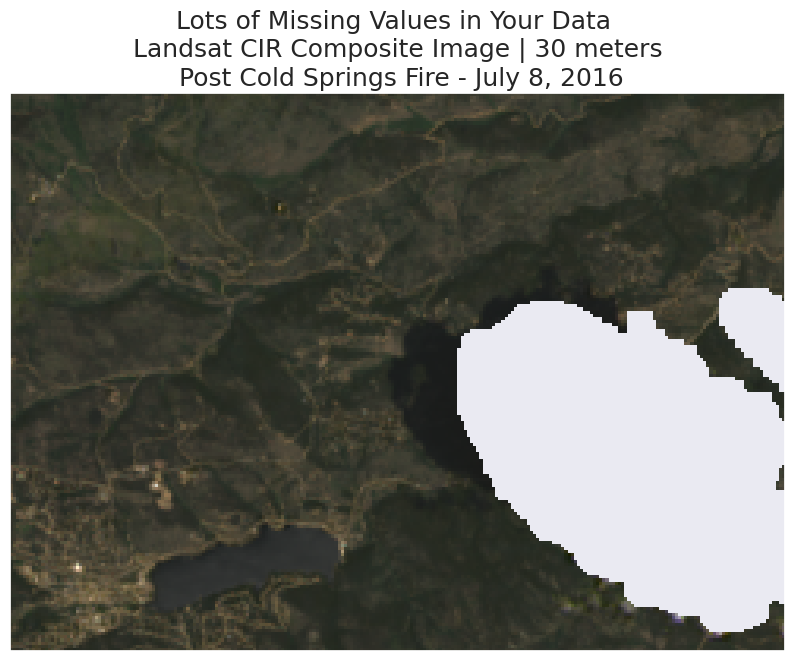

In [8]:
ep.plot_rgb(landsat_pre_cl_masked, rgb=[2, 1, 0], title="Lots of Missing Values in Your Data \n Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire - July 8, 2016")
plt.show()

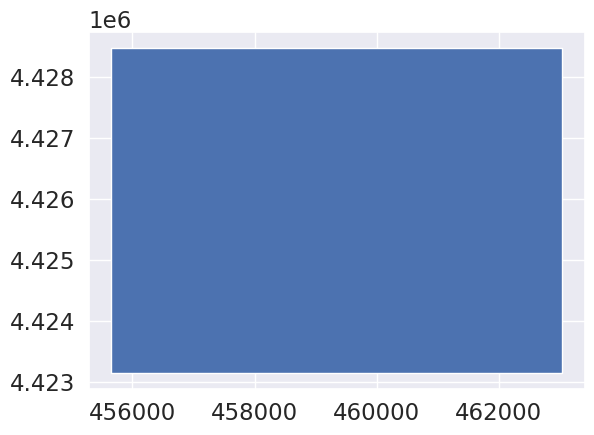

In [9]:
landsat_pre_cloud_ext_bds = landsat_pre.rio.bounds()

df = {'id': [1],
      'geometry': box(*landsat_pre.rio.bounds())}
clip_gdf = gpd.GeoDataFrame(df, crs=landsat_pre.rio.crs)
clip_gdf.plot()
plt.show()

In [10]:
cloud_free_path = os.path.join("cs-test-landsat", "*band[2-4]*.tif")
landsat_paths_pre_cloud_free = sorted(glob(cloud_free_path))
landsat_pre_cloud_free = process_bands(landsat_paths_pre_cloud_free, stack=True, crop_layer=clip_gdf)

landsat_pre_cloud_free

I'm stacking your data now.


<xarray.DataArray (band: 3, y: 177, x: 246)> Size: 1MB
array([[[590., 629., 636., ..., 218., 234., 283.],
        [546., 580., 598., ..., 248., 270., 314.],
        [484., 503., 506., ..., 284., 325., 348.],
        ...,
        [434., 431., 438., ..., 290., 291., 303.],
        [441., 490., 478., ..., 292., 312., 313.],
        [340., 278., 297., ..., 299., 334., 337.]],

       [[781., 808., 828., ..., 461., 485., 535.],
        [748., 795., 807., ..., 491., 519., 574.],
        [727., 754., 743., ..., 535., 590., 627.],
        ...,
        [722., 724., 722., ..., 550., 554., 569.],
        [706., 777., 756., ..., 546., 577., 591.],
        [578., 484., 500., ..., 548., 590., 607.]],

       [[770., 839., 845., ..., 331., 363., 412.],
        [730., 793., 812., ..., 379., 421., 479.],
        [657., 692., 691., ..., 441., 522., 573.],
        ...,
        [697., 789., 797., ..., 497., 486., 505.],
        [837., 788., 802., ..., 476., 505., 508.],
        [542., 477., 465., ..., 510., 536., 536.]]])
Coordinates:
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
  * band         (band) int64 24B 1 2 3
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    Band_1:         band 2 surface reflectance
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      band 2 surface reflectance

In [11]:
landsat_no_clouds_bds = landsat_pre_cloud_free.rio.bounds()
landsat_pre_cloud_ext_bds = landsat_pre.rio.bounds()
print("The cloud free data bounds are:", landsat_no_clouds_bds)
print("The original cloud covered data bounds are:",  landsat_pre_cl_masked.rio.bounds())
print("Are the bounds the same?", landsat_no_clouds_bds == landsat_pre_cloud_ext_bds)

The cloud free data bounds are: (455655.0, 4423155.0, 463035.0, 4428465.0)
The original cloud covered data bounds are: (455655.0, 4423155.0, 463035.0, 4428465.0)
Are the bounds the same? True


In [12]:
cloud_free_scene_bds = box(*landsat_no_clouds_bds)
cloudy_scene_bds = box(*landsat_pre_cloud_ext_bds)

cloud_free_scene_bds.intersects(cloudy_scene_bds)

True

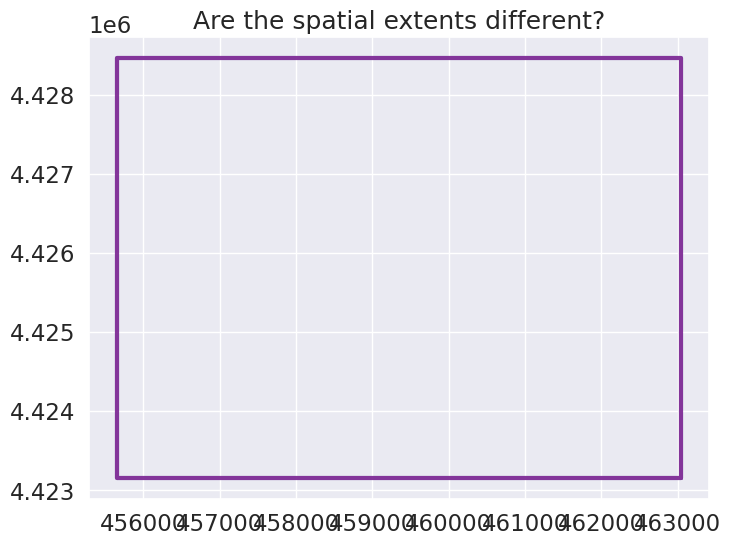

In [13]:
x, y = cloud_free_scene_bds.exterior.xy
x1, y1 = cloudy_scene_bds.exterior.xy

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(x, y, color='#6699cc', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)

ax.plot(x1, y1, color='purple', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)

ax.set_title('Are the spatial extents different?')

plt.show()

In [14]:
landsat_pre.rio.crs == landsat_pre_cloud_free.rio.crs

True

In [15]:
landsat_pre.shape == landsat_pre_cloud_free.shape

True

In [16]:
mask = landsat_pre_cl_masked.isnull()

landsat_pre_clouds_filled = xr.where(mask, landsat_pre_cloud_free, landsat_pre_cl_masked)
landsat_pre_clouds_filled

<xarray.DataArray (band: 3, y: 177, x: 246)> Size: 1MB
array([[[ 443.,  456.,  446., ...,  213.,  251.,  293.],
        [ 408.,  420.,  436., ...,  226.,  272.,  332.],
        [ 356.,  375.,  373., ...,  261.,  329.,  383.],
        ...,
        [ 407.,  427.,  428., ...,  306.,  273.,  216.],
        [ 545.,  552.,  580., ...,  307.,  315.,  252.],
        [ 350.,  221.,  233., ...,  320.,  348.,  315.]],

       [[ 635.,  641.,  629., ...,  360.,  397.,  454.],
        [ 601.,  617.,  620., ...,  380.,  418.,  509.],
        [ 587.,  600.,  573., ...,  431.,  513.,  603.],
        ...,
        [ 679.,  742.,  729., ...,  493.,  482.,  459.],
        [ 816.,  827.,  824., ...,  461.,  502.,  485.],
        [ 526.,  388.,  364., ...,  463.,  501.,  512.]],

       [[ 625.,  671.,  651., ...,  265.,  307.,  340.],
        [ 568.,  620.,  627., ...,  309.,  354.,  431.],
        [ 513.,  510.,  515., ...,  362.,  464.,  565.],
        ...,
        [ 725.,  834.,  864., ...,  485.,  467.,  457.],
        [1031.,  864.,  844., ...,  438.,  457.,  429.],
        [ 525.,  432.,  411., ...,  465.,  472.,  451.]]])
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int64 8B 0

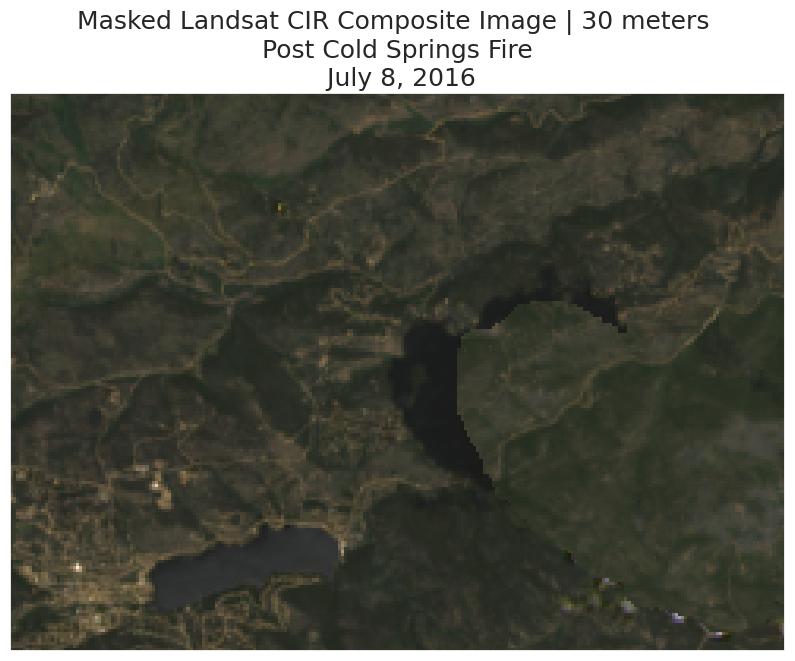

In [17]:
ep.plot_rgb(landsat_pre_clouds_filled.values, rgb=[2, 1, 0], title="Masked Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016")
plt.show()